In [81]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torch.utils.data import DataLoader, TensorDataset  
import torch.nn.functional as F

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  
from sklearn.compose import ColumnTransformer

In [82]:
# I imported nn optim and DataLoader batches data for training 
# PyTorch does not bundle everything like keras.

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [84]:
# Set random seed for consistent results
torch.manual_seed(42)

In [85]:
# Load the DS 
df = pd.read_csv('cleaned_data.csv')
df.head(10)
# The DS has 26280 rows and 9 columns

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,Load_Type_Maximum_Load,Load_Type_Medium_Load,time_minutes_sin,time_minutes_cos,month_sin,month_cos
0,3.17,2.95,0.0,0,0,0.065403,0.997859,0.5,0.866025
1,4.00,4.46,0.0,0,0,0.130526,0.991445,0.5,0.866025
2,3.24,3.28,0.0,0,0,0.195090,0.980785,0.5,0.866025
3,3.31,3.56,0.0,0,0,0.258819,0.965926,0.5,0.866025
4,3.82,4.50,0.0,0,0,0.321439,0.946930,0.5,0.866025
5,3.28,3.56,0.0,0,0,0.382683,0.923880,0.5,0.866025
6,3.60,4.14,0.0,0,0,0.442289,0.896873,0.5,0.866025
7,3.60,4.28,0.0,0,0,0.500000,0.866025,0.5,0.866025
8,3.28,3.64,0.0,0,0,0.555570,0.831470,0.5,0.866025
9,3.78,4.72,0.0,0,0,0.608761,0.793353,0.5,0.866025


In [86]:
df.shape

(26280, 9)

In [87]:
# Since I have done preprocessing already, I need to convert NumPy arrays to tensor, create data loaders for training.

In [88]:
X = df.drop('Usage_kWh', axis=1)
y = df['Usage_kWh']


# I can not use random splitting, because the DS is time series
n = len(X)
# Calculating where the training data should end
train_end = int(n*0.80)
# Calculating where the val data should end
val_end = train_end + int(n*0.10)  
# Taking first 80% of the DS for training
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
# Taking next 10% of the DS for val 
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
# Taking last 10% of the DS for test
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]


# I dont need to scale time columns because they are already between -1 and 1
# So I will use RobustScaler for normal features
time_columns = ['time_minutes_sin', 'time_minutes_cos', 'month_sin', 'month_cos']
normal_features = [col for col in X_train.columns if col not in time_columns]
preprocessor = ColumnTransformer(transformers=[('robust', RobustScaler(),
    normal_features)],remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

print('Shape of training data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_val.shape, y_val.shape)
print('Shape of test data:', X_test.shape, y_test.shape)

Shape of training data: (21024, 8) (21024,)
Shape of validation data: (2628, 8) (2628,)
Shape of test data: (2628, 8) (2628,)


In [89]:
# Converting NumPy array to torch tensor:
# I am going to convert the Numpy arrays to tensor of type float32, for y I will add extra dimension to make it 2D.
# because PyTorch expects target tensor to have the same shape as model output, Finally I will pack the tensors into TensorDataset and DataLoader.

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
# I converted the NumPy arrays to torch.tensor with dtype=torch.float32

# creating DS object when data is already in tensors:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Creating DataLoader for batching
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size , shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size , shuffle=False)

# I set shuffle to true for the training loader, so the model can see batches in random order each epochs. 
# Since time columns are encoded already, shuffling them wont leak data.

<center><h2>Building the ANN Model<h2></center>

In [ ]:
# I am going to create ANN in PyTorch, I define fully connected feed-forward network with hidden layers.
# Since the target value is continuous, the output has 1 neuron like keras model.
# I have 8 input columns, I will start with 5 layers, I will use ReLU to learn non linearity.
# Dropout can be helpful for regularization.

In [ ]:
class EnergyANN(nn.Module):
  def __init__(self):
    super(EnergyANN, self).__init__()
    
    # Layers
    # Since the DS is scaled, I wont use bias
    self.fc1 = nn.Linear(X_train.shape[1], 512, bias=False)
    self.fc2 = nn.Linear(512, 256, bias=False)
    self.fc3 = nn.Linear(256, 240, bias=False)
    self.fc4 = nn.Linear(240, 128, bias=False)
    self.fc5 = nn.Linear(128, 120, bias=False)
    self.fc6 = nn.Linear(120, 1, bias=False)

    # Batch normalization for smooth training
    self.batch_norm1 = nn.BatchNorm1d(512)
    self.batch_norm2 = nn.BatchNorm1d(256)
    self.batch_norm3 = nn.BatchNorm1d(240)
    self.batch_norm4 = nn.BatchNorm1d(128)
    self.batch_norm5 = nn.BatchNorm1d(120)

    #  dropout layers
    self.dropout1 = nn.Dropout(0.15)   
    self.dropout2 = nn.Dropout(0.15)
    self.dropout3 = nn.Dropout(0.1)
    #self.dropout4 = nn.Dropout(0.1)
    #self.dropout5 = nn.Dropout(0.05) 

  def forward(self, x):
    x = self.fc1(x); x = self.batch_norm1(x); x = F.relu(x); x = self.dropout1(x)
    x = self.fc2(x); x = self.batch_norm2(x); x = F.relu(x); x = self.dropout2(x)
    x = self.fc3(x); x = self.batch_norm3(x); x = F.relu(x); x = self.dropout3(x)
    x = self.fc4(x); x = self.batch_norm4(x); x = F.relu(x)
    x = self.fc5(x); x = self.batch_norm5(x); x = F.relu(x)
    x = self.fc6(x)
    return x

model = EnergyANN().to(device)
print(model)

# Source: https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
# https://medium.com/@hassaanidrees7/mastering-linear-regression-with-pytorch-from-basics-to-implementation-f5e348e036f6

EnergyANN(
  (fc1): Linear(in_features=8, out_features=512, bias=False)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (fc3): Linear(in_features=256, out_features=240, bias=False)
  (fc4): Linear(in_features=240, out_features=128, bias=False)
  (fc5): Linear(in_features=128, out_features=120, bias=False)
  (fc6): Linear(in_features=120, out_features=1, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm5): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.15, inplace=False)
  (dropout2): Dropout(p=0.15, inplace=False)
  (dropout3): Dropout(p=0.1, inplac

In [ ]:
# Loss Function and Optimizer algorithm:

# Since my target value is continuous, I have two options for the loss function:
# MSE and MAE, mse is sensitive to outliers and mae is more robust. But has less smooth gradients.
# In keras workflow, I used mse as the loss function for stability and mae as metrics.
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#  Scheduler for learning rate. 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

<center><h2>Training loop<h2></center>

In [ ]:
# In this step, I will define the training loop for the model.
# Training loop goes over epochs and batches, computing the loss and updating weights by backpropagation.
# In keras I did not need to do this manually.

# For monitoring the training process, I will define dictionary.
history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'learning_rate': []}


best_val_loss = float('inf')
early_stopping_patience = 20
patience_counter = 0
epochs = 150

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss_sum = 0.0

    for X_batch, y_batch in train_loader:
        # Moving batches to the device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # I should clear old gradient
        optimizer.zero_grad()
        # Forward pass:
        y_pred = model(X_batch)
        # Calculating loss 
        loss = loss_function(y_pred, y_batch)
        # computing  gradients for this batch
        loss.backward()
        # Updating weights using the gradients from loss.backward()
        optimizer.step()
        # Converting the average to total
        train_loss_sum += loss.item() * X_batch.size(0) 
    train_loss = train_loss_sum / len(train_dataset)
    history['train_loss'].append(train_loss)

    # Evaluation:
    model.eval()
    val_mae_sum = 0.0
    val_loss_sum = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            # I accumulate val_loss and val_mae 
            val_loss_sum += loss.item()*X_batch.size(0)
            # I will divide by total samples later to get mae 
            val_mae_sum += torch.sum(torch.abs(y_pred - y_batch)).item()

    # Calculating mse loss and mae
    val_loss = val_loss_sum / len(val_dataset)
    val_mae = val_mae_sum / len(val_dataset)

    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    
    # Print epoch results
    print(f"Epoch {epoch}/{epochs} - "f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - " f"Val MAE: {val_mae:.4f} - "
          f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stop:
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
        
    else:
        patience_counter += 1
        scheduler.step(val_loss)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break

if best_model: 
    model.load_state_dict(best_model)

# Source: https://matrixtrak.com/pytorch-training-workflow-best-practices-for-efficient-model-development/

Epoch 1/200 - Train Loss: 757.9344 - Val Loss: 325.0309 - Val MAE: 11.9299 - Learning Rate: 0.001000
Epoch 2/200 - Train Loss: 150.1814 - Val Loss: 48.7622 - Val MAE: 3.5859 - Learning Rate: 0.001000
Epoch 3/200 - Train Loss: 65.5250 - Val Loss: 42.7215 - Val MAE: 3.2008 - Learning Rate: 0.001000
Epoch 4/200 - Train Loss: 63.5316 - Val Loss: 35.4278 - Val MAE: 3.0131 - Learning Rate: 0.001000
Epoch 5/200 - Train Loss: 62.0192 - Val Loss: 33.1288 - Val MAE: 2.8356 - Learning Rate: 0.001000
Epoch 6/200 - Train Loss: 62.4042 - Val Loss: 32.9934 - Val MAE: 2.9583 - Learning Rate: 0.001000
Epoch 7/200 - Train Loss: 59.4993 - Val Loss: 33.6324 - Val MAE: 2.7947 - Learning Rate: 0.001000
Epoch 8/200 - Train Loss: 58.2228 - Val Loss: 32.6520 - Val MAE: 2.7475 - Learning Rate: 0.001000
Epoch 9/200 - Train Loss: 57.3737 - Val Loss: 34.3218 - Val MAE: 2.7319 - Learning Rate: 0.001000
Epoch 10/200 - Train Loss: 56.6626 - Val Loss: 32.5557 - Val MAE: 2.7354 - Learning Rate: 0.001000
Epoch 11/200 - 

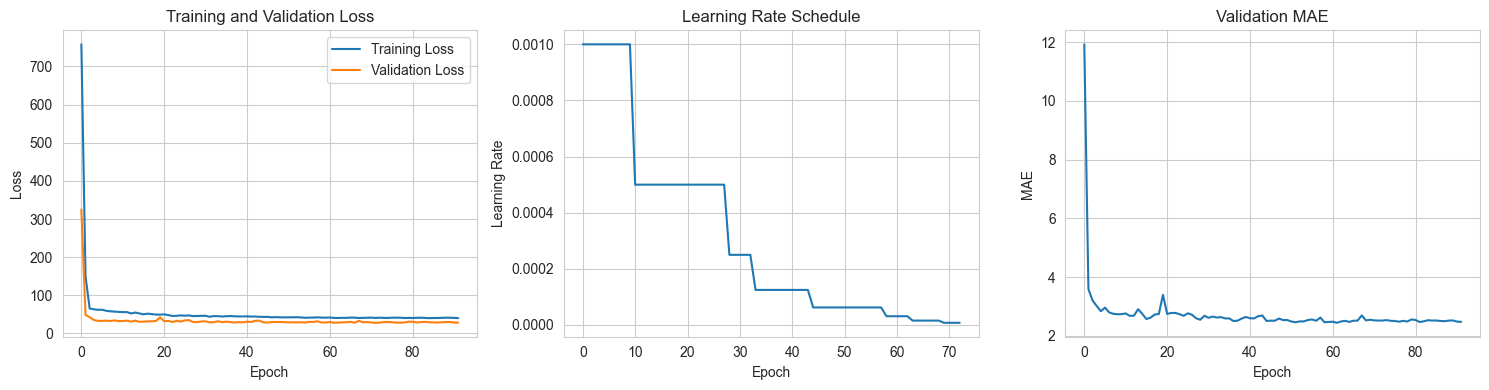

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# MSE
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Learning rate
ax2.plot(history['learning_rate'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.grid(True)

# MAE
ax3.plot(history['val_mae'])
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation MAE')
ax3.set_title('MAE')
ax3.grid(True)

plt.tight_layout()
plt.show()


In [95]:
model.eval()
test_mae = 0.0
test_mse = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        
        test_mae += torch.sum(torch.abs(y_pred - y_batch)).item()
        test_mse += torch.sum((y_pred - y_batch) ** 2).item()
        
        all_predictions.extend(y_pred.cpu().numpy().flatten())
        all_targets.extend(y_batch.cpu().numpy().flatten())

test_mae /= len(test_dataset)
test_mse /= len(test_dataset)
test_rmse = np.sqrt(test_mse)

# Calculate R2 score
test_r2 = r2_score(all_targets, all_predictions)

print(f"Test MAE = {test_mae:.4f}")
print(f"Test MSE = {test_mse:.4f}")
print(f"Test RMSE = {test_rmse:.4f}")
print(f"Test R2 Score = {test_r2:.4f}")


Test MAE = 1.7583
Test MSE = 12.5914
Test RMSE = 3.5484
Test R2 Score = 0.9774


In [96]:
# predictions
examples = 12
X_sample = X_test_tensor[:examples].to(device)
y_sample = y_test_tensor[:examples]
preds = model(X_sample)
print("Predicted vs Actual:")
for pred, true in zip(preds.cpu().flatten(), y_sample.flatten()):
    print(f"{pred.item():.2f} vs {true.item():.2f}")


Predicted vs Actual:
2.97 vs 4.25
2.94 vs 3.64
2.94 vs 3.60
2.95 vs 3.13
2.95 vs 3.02
2.93 vs 3.02
2.91 vs 3.10
2.91 vs 3.02
2.89 vs 3.06
2.86 vs 3.02
2.87 vs 3.02
2.94 vs 3.10


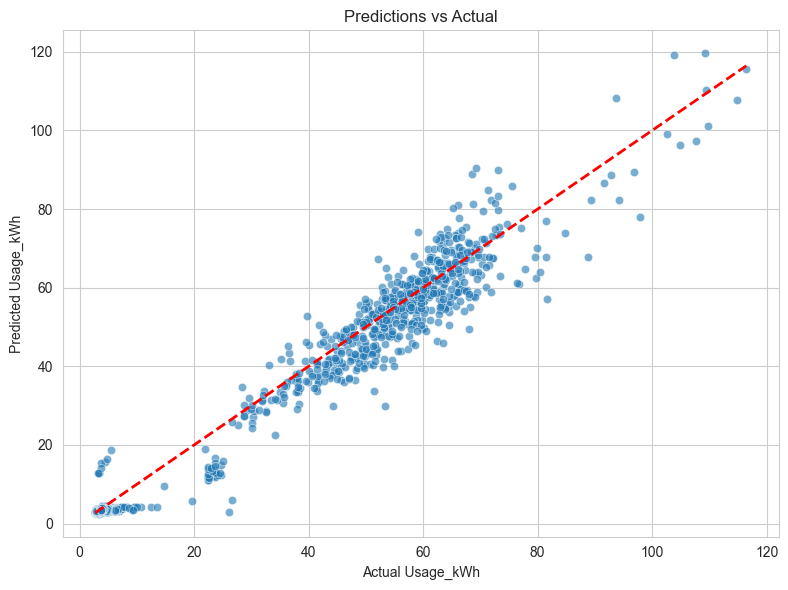

In [97]:
actuals = np.array(all_targets)
predictions = np.array(all_predictions)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actuals, y=predictions, alpha=0.6)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh')
plt.title('Predictions vs Actual')
plt.tight_layout()
plt.show()
